# Import Dependancies

In [1]:
#pip install yfinance
#pip install mplfinance

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import math
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import mplfinance as mpf
from matplotlib.lines import Line2D

# Define Variables & Extract Data

In [3]:
start = dt.datetime.today()-dt.timedelta(360)
end = dt.datetime.today()
s = dt.datetime.today()-dt.timedelta(90)
e = dt.datetime.today()
st = dt.datetime.today()-dt.timedelta(2)
ed = dt.datetime.today()
ticker = 'NVDA'

In [4]:
df = yf.download(ticker, start, end)
df.head()

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-06-17  177.744995  188.350006  177.562500  186.572495  186.445587   
2021-06-18  187.839996  193.750000  185.839996  186.387497  186.260696   
2021-06-21  184.352493  185.365005  178.227493  184.272507  184.147156   
2021-06-22  184.714996  189.637497  183.860001  188.867493  188.739014   
2021-06-23  190.077499  191.527496  189.077499  190.572495  190.442856   

              Volume  
Date                  
2021-06-17  80965600  
2021-06-18  96885600  
2021-06-21  67238400  
2021-06-22  58014400  
2021-06-23  33235600

In [5]:
dfp = yf.download(ticker, s, e)
dfp.tail()

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-06-06  191.389999  193.369995  185.639999  187.860001  187.820297   
2022-06-07  184.720001  190.000000  181.880005  189.259995  189.219986   
2022-06-08  187.990005  191.800003  185.350006  186.479996  186.479996   
2022-06-09  184.809998  189.330002  180.410004  180.479996  180.479996   
2022-06-10  176.000000  176.970001  168.690002  169.740005  169.740005   

              Volume  
Date                  
2022-06-06  42240600  
2022-06-07  38891400  
2022-06-08  36325200  
2022-06-09  39557400  
2022-06-10  46524800

In [6]:
dfv = yf.download(ticker, st, ed, interval = '5m')
dfv.head()

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close  \
Datetime                                                                    
2022-06-10 09:30:00-04:00  176.000000  176.559998  172.910004  173.214996   
2022-06-10 09:35:00-04:00  173.770004  175.309998  173.479996  174.785004   
2022-06-10 09:40:00-04:00  175.250000  176.601593  174.869995  176.556000   
2022-06-10 09:45:00-04:00  176.750000  176.960007  175.195007  175.750595   
2022-06-10 09:50:00-04:00  175.500000  175.500000  174.179993  174.450104   

                            Adj Close   Volume  
Datetime                                        
2022-06-10 09:30:00-04:00  173.214996  3337407  
2022-06-10 09:35:00-04:00  174.785004  1262326  
2022-06-10 09:40:00-04:00  176.556000   829716  
2022-06-10 09:45:00-04:00  175.750595   983112  
2022-06-10 09:50:00-04:00  174.450104   756533

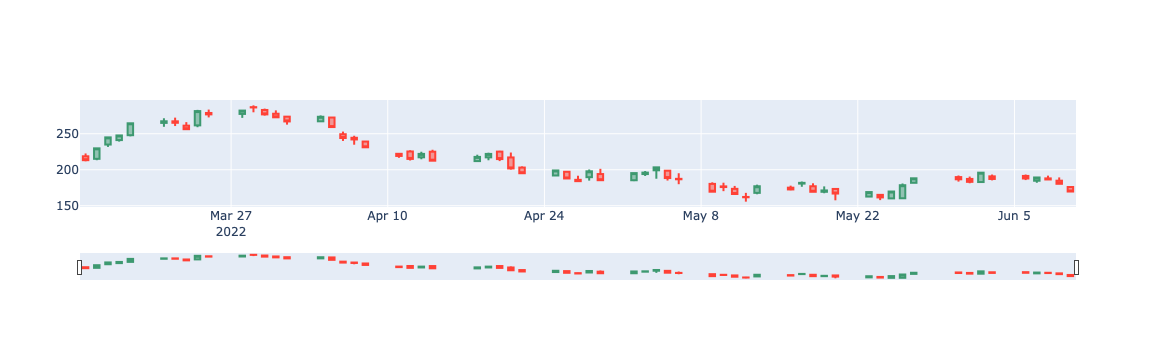

In [7]:
fig = go.Figure(data=[go.Candlestick(x=dfp.index,
                open=dfp['Open'],
                high=dfp['High'],
                low=dfp['Low'],
                close=dfp['Close'])])
fig.show()

# VWAP Code

In [8]:
dfv['VWAP'] = (dfv.Volume * (dfv.High + dfv.Low) / 2).cumsum() / dfv.Volume.cumsum()
dfv['VWAP_MEAN_DIFF'] = ((dfv.High + dfv.Low) / 2) - dfv.VWAP
dfv['SQ_DIFF'] = dfv.VWAP_MEAN_DIFF.apply(lambda x: math.pow(x, 2))
dfv['SQ_DIFF_MEAN'] = dfv.SQ_DIFF.expanding().mean()
dfv['STDEV_TT'] = dfv.SQ_DIFF_MEAN.apply(math.sqrt)

stdev_multiple_1 = 1.28
stdev_multiple_2 = 2.01
stdev_multiple_3 = 2.51

dfv['STDEV_1'] = dfv.VWAP + stdev_multiple_1 * dfv['STDEV_TT']
dfv['STDEV_N1'] = dfv.VWAP - stdev_multiple_1 * dfv['STDEV_TT']

# MACD Code

In [9]:
def MACD(df,a,b,c):
  df = df.copy()
  df['Fast_EMA']=df['Adj Close'].ewm(span = a, min_periods = a).mean()
  df['Slow_EMA']=df['Adj Close'].ewm(span = b, min_periods = b).mean()
  df['MACD'] = df['Fast_EMA']-df['Slow_EMA']
  df['Signal'] = df['MACD'].ewm(span = c, min_periods = c).mean()
  df['Histogram'] = df['MACD'] - df['Signal']
  df['Action'] = np.where(df['MACD'] > df['Signal'], 1, 0)
  df['Action'] = np.where(df['MACD'] < df['Signal'], -1, df['Action'])
  df['Return'] = df['Adj Close'].pct_change()
  df['System_Return'] = df['Action'] * df['Return']
  df['Entry'] = df.Action.diff()
  df.dropna(inplace = True)
  return df
df1 = MACD(df,12,26,9)

In [10]:
# def implement_macd_strategy(df1):    
#     prices = df1['Adj Close']
#     buy_price = []
#     sell_price = []
#     macd_signal = []
#     signal = 0

#     for i in range(len(df1)):
#         if df1['MACD'][i] > df1['Signal'][i]:
#             if signal != 1:
#                 buy_price.append(prices[i])
#                 sell_price.append(np.nan)
#                 signal = 1
#                 macd_signal.append(signal)
#             else:
#                 buy_price.append(np.nan)
#                 sell_price.append(np.nan)
#                 macd_signal.append(0)
#         elif df1['MACD'][i] < df1['Signal'][i]:
#             if signal != -1:
#                 buy_price.append(np.nan)
#                 sell_price.append(prices[i])
#                 signal = -1
#                 macd_signal.append(signal)
#             else:
#                 buy_price.append(np.nan)
#                 sell_price.append(np.nan)
#                 macd_signal.append(0)
#         else:
#             buy_price.append(np.nan)
#             sell_price.append(np.nan)
#             macd_signal.append(0)
            
#     return buy_price, sell_price, macd_signal
            
# buy_price, sell_price, macd_signal = implement_macd_strategy(df1)


# Moving Average Crossovers Code

In [11]:
def SMA(df, a, b):
  df = df.copy()
  df['9-day'] = df['Adj Close'].rolling(a).mean()
  df['21-day'] = df['Adj Close'].rolling(b).mean()
  df['signal'] = np.where(df['9-day'] > df['21-day'], 1, 0)
  df['signal'] = np.where(df['9-day'] < df['21-day'], -1, df['signal'])
  df['Return'] = df['Adj Close'].pct_change()
  df['System_Return'] = df['signal'] * df['Return']
  df['Entry'] = df.signal.diff()
  df.dropna(inplace=True)
  df
  return df
df2 = SMA(df, 50, 200)

# ATR Code

In [12]:
def ATR(df,n):
    "function to calculate True Range and Average True Range"
    df = df.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    dfx = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return dfx
df3 = ATR(df,14)

# Bollinger Bands Code

In [13]:
def Bollinger_Bands(df, a, b):
  df = df.copy()
  df['SMA'] = df['Adj Close'].rolling(a).mean()
  df['Std Dev'] = df['Adj Close'].rolling(a).std()
  df['Upper'] = df['SMA'] + b * df['Std Dev']
  df['Lower'] = df['SMA'] - b * df['Std Dev']
  df['Buy'] = np.where(df['Lower'] > df['Adj Close'], True, False)
  df['Sell'] = np.where(df['Upper'] < df['Adj Close'], True, False)
  df.dropna(inplace = True)
  return df
df4 = Bollinger_Bands(df, 20, 2)
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = implement_bb_strategy(df4['Adj Close'], df4['Lower'], df4['Upper'])

# Ichimoku Cloud Code

In [14]:
def ichimoku_cloud(df, a, b, c):
  df = df.copy()
  nine_h = df['High'].rolling(a).max()
  nine_l = df['Low'].rolling(a).min()
  tsix_h = df['High'].rolling(b).max()
  tsix_l = df['Low'].rolling(b).min()
  df['Fast_Moving_Average'] = (nine_h + nine_l)/2
  df['Slow_Moving_Average'] = (tsix_h + tsix_l)/2
  df['Leading_Span_A'] = ((df['Fast_Moving_Average'] + df['Slow_Moving_Average'])/2).shift(b)
  fifty2_h = df['High'].rolling(c).max()
  fifty2_l = df['Low'].rolling(c).min()
  df['Leading_Span_B'] = ((fifty2_h + fifty2_l)/2).shift(b)
  df['Chikou_Span'] = df['Adj Close'].shift(-b)
  df['Action'] = np.where(df['Fast_Moving_Average'] > df['Slow_Moving_Average'], 1, 0)
  df['Action'] = np.where(df['Fast_Moving_Average'] < df['Fast_Moving_Average'], -1, df['Action'])
  df['Entry'] = df.Action.diff()
  return df
df5 = ichimoku_cloud(df, 9, 26, 52)

# ADX Code

In [15]:
def ADX(df, n = 14):
    "function to calculate ADX"
    df = df.copy()
    dfz = ATR(df, n)
    df["upmove"] = df["High"] - df["High"].shift(1)
    df["downmove"] = df["Low"].shift(1) - df["Low"]
    df["+dm"] = np.where((df["upmove"]>df["downmove"]) & (df["upmove"] >0), df["upmove"], 0)
    df["-dm"] = np.where((df["downmove"]>df["upmove"]) & (df["downmove"] >0), df["downmove"], 0)
    df["+di"] = 100 * (df["+dm"]/dfz["ATR"]).ewm(alpha=1/n, min_periods=n).mean()
    df["-di"] = 100 * (df["-dm"]/dfz["ATR"]).ewm(alpha=1/n, min_periods=n).mean()
    df["ADX"] = 100* abs((df["+di"] - df["-di"])/(df["+di"] + df["-di"])).ewm(alpha=1/n, min_periods=n).mean()
    return df
df6 = ADX(df, n = 14)
print(df6['ADX'])

Date
2021-06-17          NaN
2021-06-18          NaN
2021-06-21          NaN
2021-06-22          NaN
2021-06-23          NaN
                ...    
2022-06-06    21.479838
2022-06-07    20.070729
2022-06-08    19.012631
2022-06-09    17.998810
2022-06-10    18.428196
Name: ADX, Length: 249, dtype: float64


# RSI Code

In [16]:
def RSI(df, n=14):
    "function to calculate RSI"
    df = df.copy()
    df["change"] = df["Adj Close"] - df["Adj Close"].shift(1)
    df["gain"] = np.where(df["change"]>=0, df["change"], 0)
    df["loss"] = np.where(df["change"]<0, -1*df["change"], 0)
    df["avgGain"] = df["gain"].ewm(alpha=1/n, min_periods=n).mean()
    df["avgLoss"] = df["loss"].ewm(alpha=1/n, min_periods=n).mean()
    df["rs"] = df["avgGain"]/df["avgLoss"]
    df["rsi"] = 100 - (100/ (1 + df["rs"]))
    return df
df7 = RSI(df, n=14)

# PSAR (Parabolic Stop & Reverse) Code

In [17]:
def psar(dfp, iaf = 0.02, maxaf = 0.2):
    length = len(dfp)
    dates = list(dfp.index)
    high = list(dfp['High'])
    low = list(dfp['Low'])
    close = list(dfp['Close'])
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = low[0]
    hp = high[0]
    lp = low[0]

    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = high[i]
                af = iaf
        if not reverse:
            if bull:
                if high[i] > hp:
                    hp = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < lp:
                    lp = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}

# Stochastic Oscillator Code

In [18]:
def add_stochastic_oscillator(df, periods=14):
    copy = df.copy()
    
    high_roll = copy["High"].rolling(periods).max()
    low_roll = copy["Low"].rolling(periods).min()
    
    # Fast stochastic indicator
    num = copy["Adj Close"] - low_roll
    denom = high_roll - low_roll
    copy["K"] = (num / denom) * 100
    
    # Slow stochastic indicator
    copy["D"] = copy["K"].rolling(3).mean()
    
    return copy
dfso = add_stochastic_oscillator(df, periods=14)

# VWAP

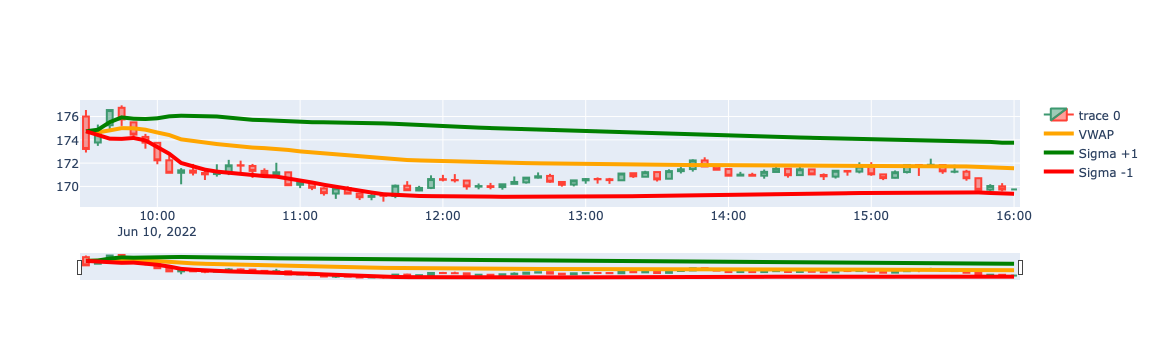

In [19]:
fig = go.Figure(data=[go.Candlestick(x=dfv.index,
                open=dfv['Open'],
                high=dfv['High'],
                low=dfv['Low'],
                close=dfv['Close'])])

fig.add_trace(go.Scatter(x=dfv.index, y=dfv['VWAP'], name='VWAP',
                         line = dict(color='orange', width=4)))

fig.add_trace(go.Scatter(x=dfv.index, y=dfv['STDEV_1'], name='Sigma +1',
                         line = dict(color='green', width=4)))

fig.add_trace(go.Scatter(x=dfv.index, y=dfv['STDEV_N1'], name='Sigma -1',
                         line = dict(color='red', width=4)))

fig.show()

# MACD

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for mu

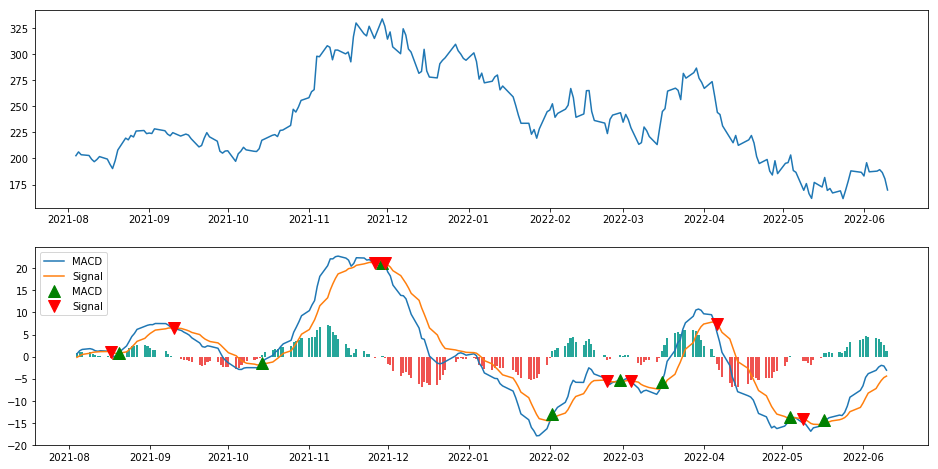

In [20]:
plt.rcParams['figure.figsize'] = 16, 8
fig, axs = plt.subplots(2)
# axs.grid(True, alpha = .3)
axs[0].plot(df1['Adj Close'], label = ticker)
axs[1].plot(df1['MACD'], label = 'MACD')
axs[1].plot(df1['Signal'], label = 'Signal')
axs[1].plot(df1.loc[df1.Entry == 2].index, df1['MACD'][df1.Entry == 2], '^',
         color = 'g', markersize = 12)
axs[1].plot(df1.loc[df1.Entry == -2].index, df1['Signal'][df1.Entry == -2], 'v',
         color = 'r', markersize = 12)
axs[1].legend(loc=2);
# axs[2].hist(df1['Histogram'], label = 'Histogram')
for i in range(len(df1)):
    if str(df1['Histogram'][i])[0] == '-':
        axs[1].bar(df1.index[i], df1['Histogram'][i], color = '#ef5350')
    else:
        axs[1].bar(df1.index[i], df1['Histogram'][i], color = '#26a69a')

In [21]:
# ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
# ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

# ax1.plot(df1['Adj Close'], color = 'skyblue', linewidth = 2, label = ticker)
# ax1.plot(df1.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
# ax1.plot(df1.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
# ax1.legend()
# ax1.set_title('MACD SIGNALS')
# ax2.plot(df1['MACD'], color = 'grey', linewidth = 1.5, label = 'MACD')
# ax2.plot(df1['Signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
# ax2.legend(loc=2)

# for i in range(len(df1)):
#     if str(df1['Histogram'][i])[0] == '-':
#         ax2.bar(df1.index[i], df1['Histogram'][i], color = '#ef5350')
#     else:
#         ax2.bar(df1.index[i], df1['Histogram'][i], color = '#26a69a')
        
# plt.legend(loc = 'upper left')
# plt.show()

# Moving Average Crossovers

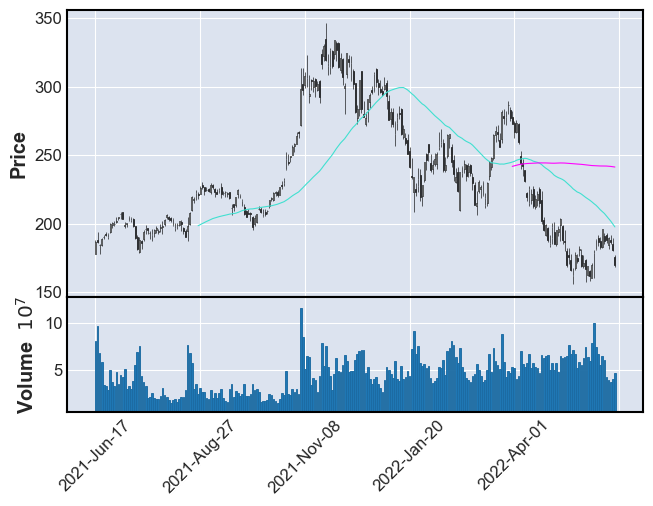

In [22]:
mpf.plot(df, type="candle", mav=(50, 200), volume=True)

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for mu

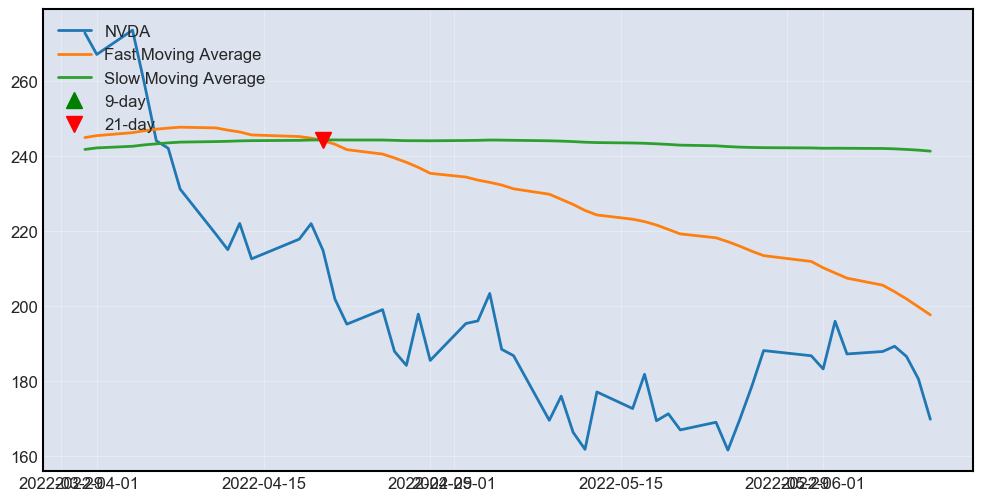

In [23]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(df2.iloc[-252:]['Adj Close'], label = ticker)
plt.plot(df2.iloc[-252:]['9-day'], label = 'Fast Moving Average')
plt.plot(df2.iloc[-252:]['21-day'], label = 'Slow Moving Average')
plt.plot(df2[-252:].loc[df2.Entry == 2].index, df2[-252:]['9-day'][df2.Entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(df2[-252:].loc[df2.Entry == -2].index, df2[-252:]['21-day'][df2.Entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

# Price, ATR, ADX & RSI

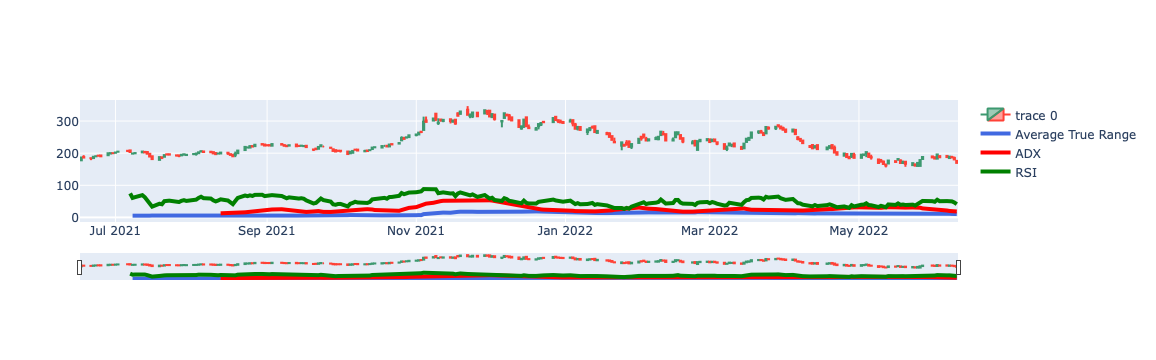

In [24]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Adj Close'])])

fig.add_trace(go.Scatter(x=df3.index, y=df3['ATR'], name='Average True Range',
                         line = dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=df6.index, y=df6['ADX'], name='ADX',
                         line = dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=df7.index, y=df7['rsi'], name='RSI',
                         line = dict(color='green', width=4)))

fig.show()

# Bolinger Bands

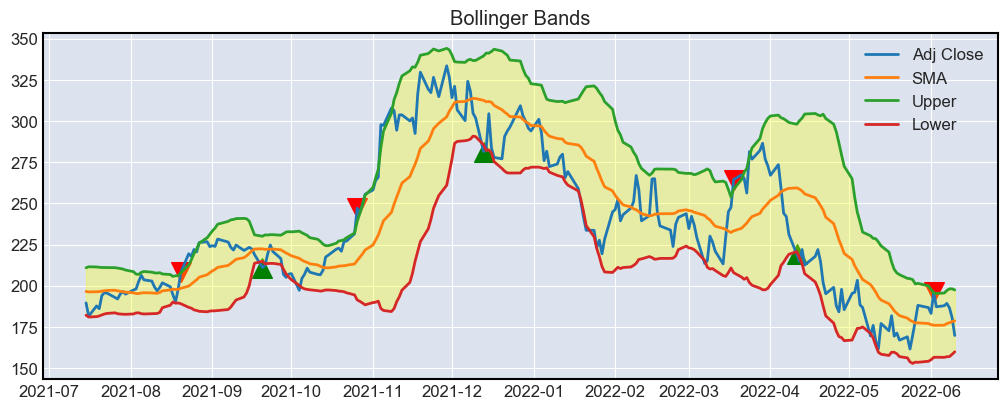

In [25]:
plt.figure(figsize = (12.33, 4.5))
plt.title('Bollinger Bands')
plt.plot(df4[['Adj Close', 'SMA', 'Upper', 'Lower']])
plt.scatter(df4.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df4.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
# plt.plot(df4.loc[df4.Buy == True].index, df4['Adj Close'][df4.Buy == True], '^',color = 'g', markersize = 8)
# plt.plot(df4.loc[df4.Sell == True].index, df4['Adj Close'][df4.Sell == True], 'v',color = 'r', markersize = 8)
plt.fill_between(df4.index, df4['Upper'], df4['Lower'], color = 'yellow', alpha = 0.3)
plt.legend(['Adj Close', 'SMA', 'Upper', 'Lower'])
plt.show()

# Ichimoku Cloud

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for mu

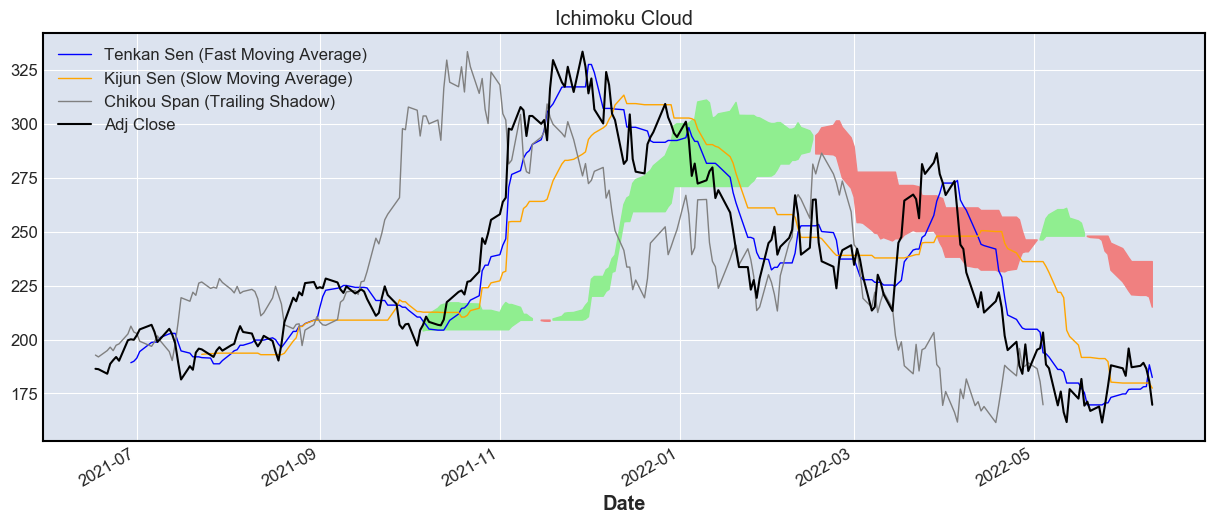

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



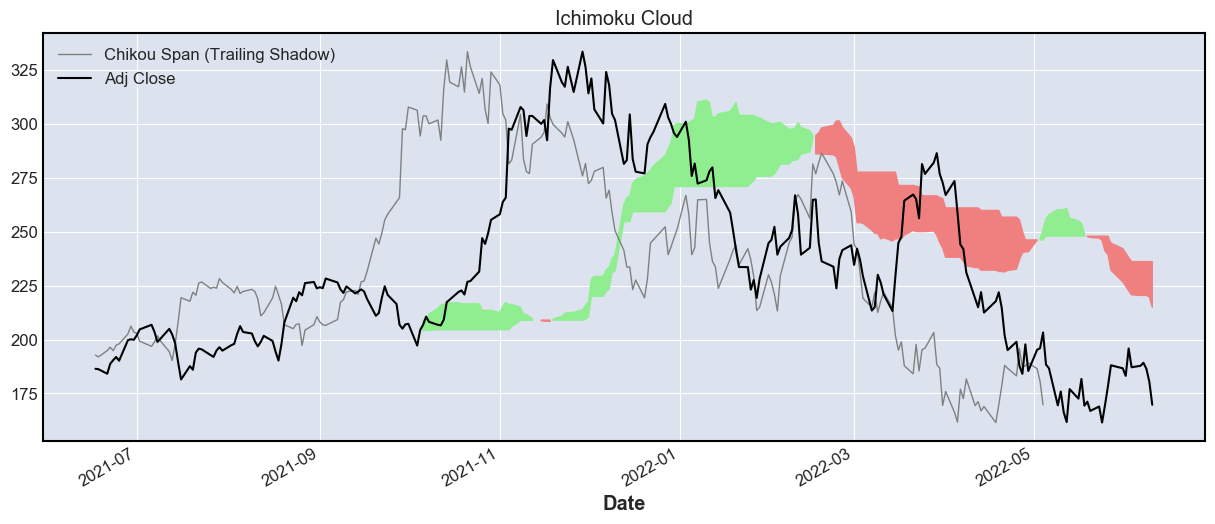

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



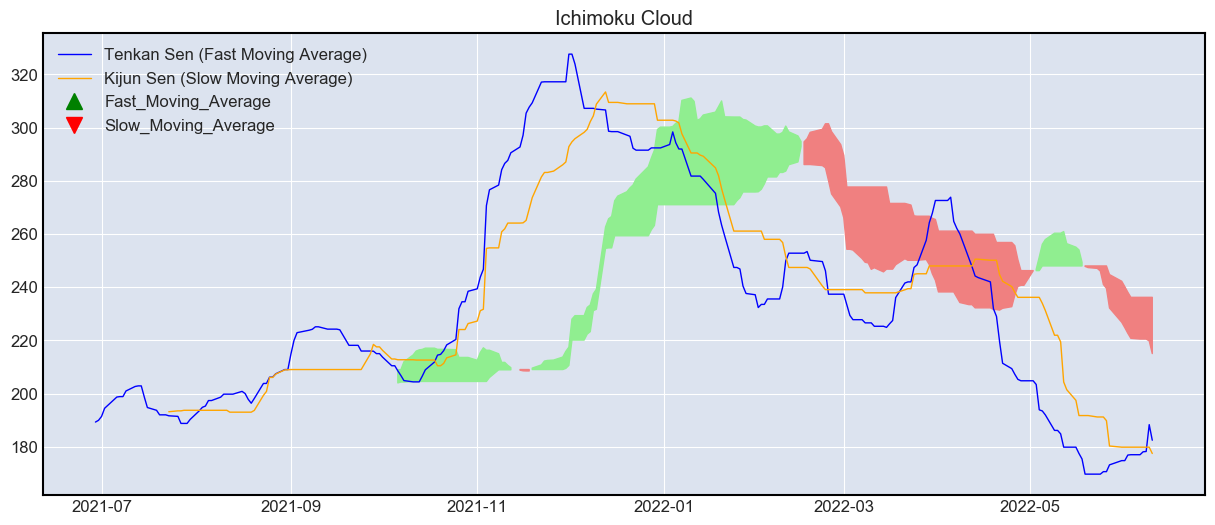

In [26]:
fig1 = plt.figure(figsize = (15, 6))
plt.title('Ichimoku Cloud')
plt.plot(df5.index, df5['Fast_Moving_Average'], label = 'Tenkan Sen (Fast Moving Average)', color = 'blue', lw = 1)
plt.plot(df5.index, df5['Slow_Moving_Average'], label = 'Kijun Sen (Slow Moving Average)', color = 'orange', lw = 1)
plt.plot(df5.index, df5['Chikou_Span'], label = 'Chikou Span (Trailing Shadow)', color = 'gray', lw = 1)
k = (df5['Adj Close'].plot(lw = 1.5, color = 'black'))
k.fill_between(df5.index, df5.Leading_Span_A, df5.Leading_Span_B, where= df5.Leading_Span_A >= df5.Leading_Span_B, color = 'lightgreen')
k.fill_between(df5.index, df5.Leading_Span_A, df5.Leading_Span_B, where= df5.Leading_Span_A < df5.Leading_Span_B, color = 'lightcoral')
plt.legend(loc=2)
plt.show()

fig2 = plt.figure(figsize = (15, 6))
plt.title('Ichimoku Cloud')
# plt.plot(df5.index, df5['Fast_Moving_Average'], label = 'Tenkan Sen (Fast Moving Average)', color = 'blue', lw = 1)
# plt.plot(df5.index, df5['Slow_Moving_Average'], label = 'Kijun Sen (Slow Moving Average)', color = 'orange', lw = 1)
plt.plot(df5.index, df5['Chikou_Span'], label = 'Chikou Span (Trailing Shadow)', color = 'gray', lw = 1)
k = (df5['Adj Close'].plot(lw = 1.5, color = 'black'))
k.fill_between(df5.index, df5.Leading_Span_A, df5.Leading_Span_B, where= df5.Leading_Span_A >= df5.Leading_Span_B, color = 'lightgreen')
k.fill_between(df5.index, df5.Leading_Span_A, df5.Leading_Span_B, where= df5.Leading_Span_A < df5.Leading_Span_B, color = 'lightcoral')
plt.legend(loc=2)
plt.show()

fig3 = plt.figure(figsize = (15, 6))
plt.title('Ichimoku Cloud')
plt.plot(df5.index, df5['Fast_Moving_Average'], label = 'Tenkan Sen (Fast Moving Average)', color = 'blue', lw = 1)
plt.plot(df5.index, df5['Slow_Moving_Average'], label = 'Kijun Sen (Slow Moving Average)', color = 'orange', lw = 1)
# plt.plot(df5.index, df5['Chikou_Span'], label = 'Chikou Span (Trailing Shadow)', color = 'gray', lw = 1)
# k = (df5['Adj Close'].plot(lw = 1.5, color = 'black'))
plt.fill_between(df5.index, df5.Leading_Span_A, df5.Leading_Span_B, where= df5.Leading_Span_A >= df5.Leading_Span_B, color = 'lightgreen')
plt.fill_between(df5.index, df5.Leading_Span_A, df5.Leading_Span_B, where= df5.Leading_Span_A < df5.Leading_Span_B, color = 'lightcoral')
plt.plot(df5[-252:].loc[df5.Entry == 2].index, df5[-252:]['Fast_Moving_Average'][df5.Entry == 2], '^', color = 'g', markersize = 12)
plt.plot(df5[-252:].loc[df5.Entry == -2].index, df5[-252:]['Slow_Moving_Average'][df5.Entry == -2], 'v', color = 'r', markersize = 12)
plt.legend(loc=2)
plt.show()


# PSAR (Parabolic Stop & Reverse)

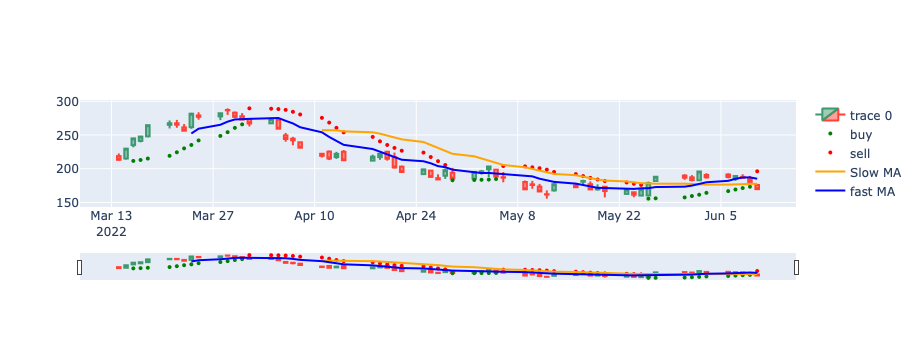

In [27]:
if __name__ == "__main__":
    import sys
    import os
    
    startidx = 0
    endidx = len(dfp)
    
    result = psar(dfp)
    dates = result['dates'][startidx:endidx]
    close = result['close'][startidx:endidx]
    psarbear = result['psarbear'][startidx:endidx]
    psarbull = result['psarbull'][startidx:endidx]
    dfp['Slow MA'] = dfp['Adj Close'].rolling(21).mean()
    dfp['Fast MA'] = dfp['Adj Close'].rolling(9).mean()
    
    # plt.title('PSAR (Parabolic Stop & Reverse)')
    # plt.plot(dates, close, label = ticker)
    # plt.plot(dates, psarbull, label = 'Buy', color = 'green')
    # plt.plot(dates, psarbear, label = 'Sell', color = 'red' )
    # plt.plot(df['200 MA'], label = '200 Day MA')
    # plt.legend()
    # plt.grid()
    # plt.show()

fig = go.Figure(data=[go.Candlestick(x=dfp.index,
                open=dfp['Open'],
                high=dfp['High'],
                low=dfp['Low'],
                close=dfp['Close'])])

fig.add_trace(go.Scatter(x=dates, y=psarbull, name='buy',mode = 'markers',
                         marker = dict(color='green', size=4)))

fig.add_trace(go.Scatter(x=dates, y=psarbear, name='sell', mode = 'markers',
                         marker = dict(color='red', size=4)))

fig.add_trace(go.Scatter(x=dfp.index, y=dfp['Slow MA'], name='Slow MA',
                         line = dict(color='orange', width=2)))

fig.add_trace(go.Scatter(x=dfp.index, y=dfp['Fast MA'], name='fast MA',
                         line = dict(color='Blue', width=2)))

fig.show()

# Stochastic Oscillator

/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/matplotlib/figure.py:2369: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



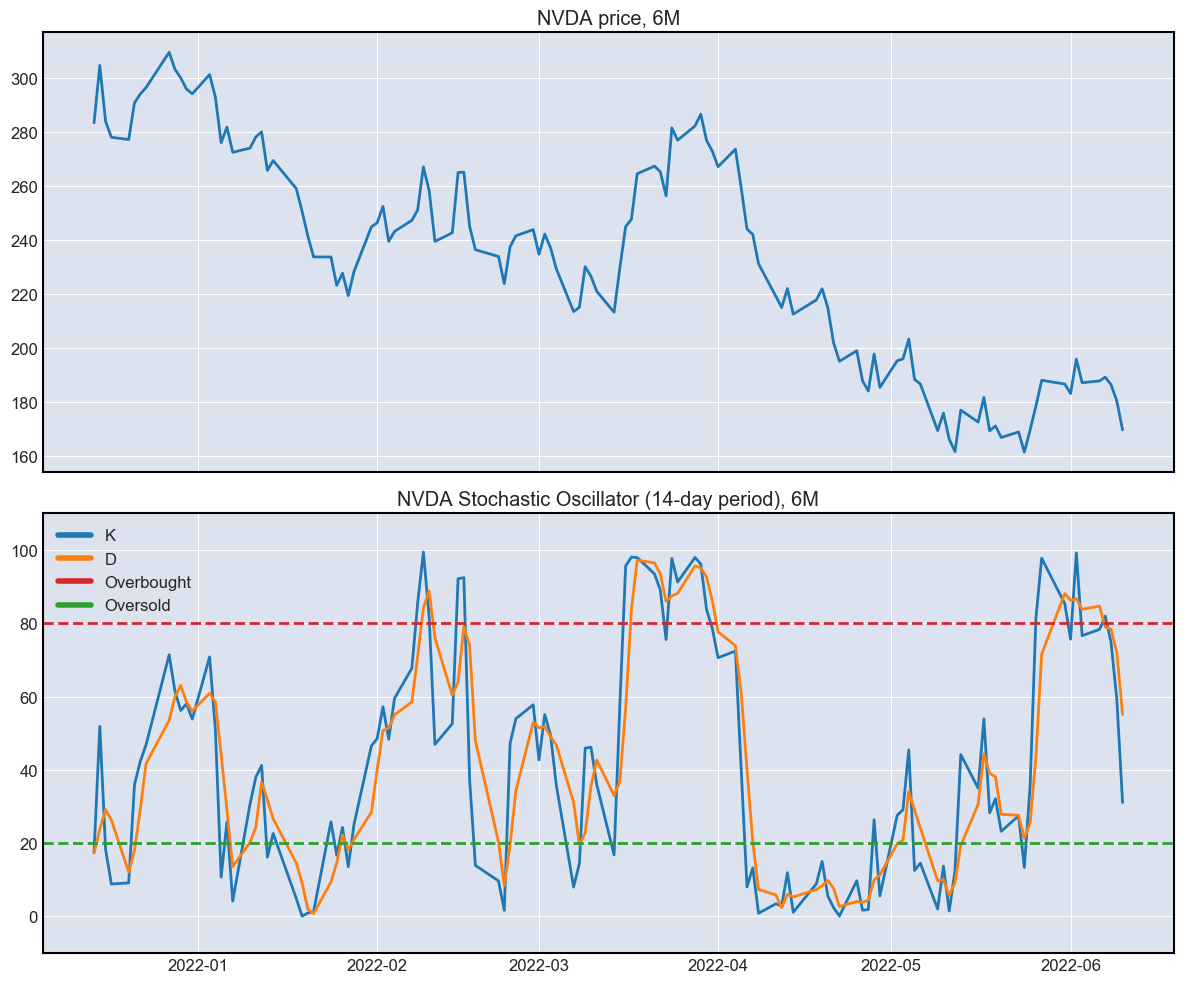

In [28]:
today = dt.datetime.now()

date_pattern = "%Y-%m-%d"
today_str = today.strftime(date_pattern)
date_ranges = {
    "1M": (today - dt.timedelta(days=30)).strftime(date_pattern),
    "3M": (today - dt.timedelta(days=90)).strftime(date_pattern),
    "6M": (today - dt.timedelta(days=180)).strftime(date_pattern),
    "1Y": (today - dt.timedelta(days=365)).strftime(date_pattern),
    "2Y": (today - dt.timedelta(days=2*365)).strftime(date_pattern),
}


def plot_stochastic_oscillator(dfso, ticker, rng, periods=14):
    start = date_ranges[rng]
    end = today_str
    temp_df = dfso[start:end]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, tight_layout=True, figsize=(12, 10))

    ax[0].set_title(f"{ticker} price, {rng}")
    ax[0].plot(temp_df["Close"], color="tab:blue")

    ax[1].set_title(f"{ticker} Stochastic Oscillator ({periods}-day period), {rng}")
    ax[1].set_ylim(-10, 110)
    ax[1].plot(temp_df["K"], color="tab:blue") # fast
    ax[1].plot(temp_df["D"], color="tab:orange") # slow

    ax[1].axhline(80, color="tab:red", ls="--")
    ax[1].axhline(20, color="tab:green", ls="--")

    custom_lines = [
        Line2D([0], [0], color="tab:blue", lw=4),
        Line2D([0], [0], color="tab:orange", lw=4),
        Line2D([0], [0], color="tab:red", lw=4),
        Line2D([0], [0], color="tab:green", lw=4),
    ]
    ax[1].legend(custom_lines, ["K", "D", "Overbought", "Oversold"], loc="best")

plot_stochastic_oscillator(dfso, ticker, "6M")

# Linear Regression

# New Section

In [29]:
dfr = pd.DataFrame()
s = dt.datetime.today()-dt.timedelta(365)
e = dt.datetime.today()

In [30]:
dfr['Close'] = yf.download(ticker, s, e)['Adj Close']
dfr.sort_values(['Date'], axis=0, ascending=False, inplace=True)
dfr.head()

[*********************100%***********************]  1 of 1 completed


Close
Date                  
2022-06-10  169.740005
2022-06-09  180.479996
2022-06-08  186.479996
2022-06-07  189.219986
2022-06-06  187.820297

In [31]:
def returns(dfr):
  dfr = dfr.copy()
  dfr['Returns'] = np.log(dfr.div(dfr.shift(-1)))
  dfr.dropna()
  dfr.drop(columns = 'Close', inplace=True)
  dfr.dropna(inplace = True)
  return dfr

In [32]:
df8 = returns(dfr)
df8.head()

Returns
Date                
2022-06-10 -0.061352
2022-06-09 -0.032704
2022-06-08 -0.014586
2022-06-07  0.007425
2022-06-06  0.003519

In [33]:
def Auto_Regressive_Model(df, n):
    df = df.copy()
    df['lag'] = df
    lags = n
    cols = []
    for lag in range(1, lags+1):
        col = 'lag{}'.format(lag)
        df[col] = df['lag'].shift(lag)
        cols.append(col)
    df.drop(columns = 'lag', inplace = True)
    df.dropna(inplace = True)
    df
    y = df[cols]
    x = df.drop(columns = cols)
    from sklearn import linear_model
    from sklearn.metrics import mean_absolute_error
    model = linear_model.LinearRegression(fit_intercept = True)
    model.fit(y,x)
    print('The intercept value is ', model.intercept_) 
    print('The Lag Coefficient values are', model.coef_)
    df['Forecast'] = model.predict(y.values)
    df
    return df

In [34]:
df8_1 = Auto_Regressive_Model(df8, 30)
df8_1.head()

The intercept value is  [0.00031789]
The Lag Coefficient values are [[ 0.00272425 -0.0691052   0.06760985  0.02062916  0.11282007  0.09294614
   0.06871687 -0.04465921 -0.08333057 -0.00141957  0.13573484  0.00723042
  -0.07517653  0.04011186 -0.0886601  -0.05367188 -0.10625562  0.01033106
  -0.02147596  0.04198321  0.12471994  0.02256689  0.02039994  0.02179874
  -0.11681342 -0.00195078  0.00919208 -0.04225425 -0.09342138  0.07758836]]


/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



Returns      lag1      lag2      lag3      lag4      lag5  \
Date                                                                     
2022-04-28  0.071607 -0.064464  0.051797  0.003526  0.036663 -0.076100   
2022-04-27 -0.020053  0.071607 -0.064464  0.051797  0.003526  0.036663   
2022-04-26 -0.057602 -0.020053  0.071607 -0.064464  0.051797  0.003526   
2022-04-25  0.019637 -0.057602 -0.020053  0.071607 -0.064464  0.051797   
2022-04-22 -0.033657  0.019637 -0.057602 -0.020053  0.071607 -0.064464   

                lag6      lag7      lag8      lag9  ...     lag22     lag23  \
Date                                                ...                       
2022-04-28 -0.009009 -0.096918  0.037347 -0.056407  ... -0.007417 -0.019032   
2022-04-27 -0.076100 -0.009009 -0.096918  0.037347  ...  0.052382 -0.007417   
2022-04-26  0.036663 -0.076100 -0.009009 -0.096918  ...  0.050318  0.052382   
2022-04-25  0.003526  0.036663 -0.076100 -0.009009  ...  0.049574  0.050318   
2022-04-22  0.051797  0.003526  0.036663 -0.076100  ... -0.045028  0.049574   

               lag24     lag25     lag26     lag27     lag28     lag29  \
Date                                                                     
2022-04-28  0.067128 -0.045529  0.003519  0.007425 -0.014586 -0.032704   
2022-04-27 -0.019032  0.067128 -0.045529  0.003519  0.007425 -0.014586   
2022-04-26 -0.007417 -0.019032  0.067128 -0.045529  0.003519  0.007425   
2022-04-25  0.052382 -0.007417 -0.019032  0.067128 -0.045529  0.003519   
2022-04-22  0.050318  0.052382 -0.007417 -0.019032  0.067128 -0.045529   

               lag30  Forecast  
Date                            
2022-04-28 -0.061352  0.001354  
2022-04-27 -0.032704  0.016371  
2022-04-26 -0.014586 -0.013072  
2022-04-25  0.007425  0.037919  
2022-04-22  0.003519 -0.018935  

[5 rows x 32 columns]

# Time Series Forecast

In [35]:
df9 = Auto_Regressive_Model(dfr, 14)
df9

The intercept value is  [6.94398085]
The Lag Coefficient values are [[ 9.22256180e-01  9.19795676e-03  1.09906999e-01 -6.81536666e-02
   9.89703163e-02  3.98574359e-04 -4.04542846e-02 -1.11065073e-01
   5.34223958e-02 -2.85906146e-02  1.89043182e-01 -1.48024465e-01
  -4.86214628e-02  3.23623513e-02]]


/Users/satishsurath/opt/anaconda3/envs/ibkr/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



Close        lag1        lag2        lag3        lag4  \
Date                                                                     
2022-05-20  166.904724  168.944275  161.505844  169.714127  178.472260   
2022-05-19  171.203812  166.904724  168.944275  161.505844  169.714127   
2022-05-18  169.344208  171.203812  166.904724  168.944275  161.505844   
2022-05-17  181.731583  169.344208  171.203812  166.904724  168.944275   
2022-05-16  172.603516  181.731583  169.344208  171.203812  166.904724   
...                ...         ...         ...         ...         ...   
2021-06-18  186.260712  184.147156  188.739029  190.442856  191.924347   
2021-06-17  186.445557  186.260712  184.147156  188.739029  190.442856   
2021-06-16  177.981339  186.445557  186.260712  184.147156  188.739029   
2021-06-15  177.763992  177.981339  186.445557  186.260712  184.147156   
2021-06-14  180.064911  177.763992  177.981339  186.445557  186.260712   

                  lag5        lag6        lag7        lag8        lag9  \
Date                                                                     
2022-05-20  188.070236  186.680542  183.161270  195.878586  187.160431   
2022-05-19  178.472260  188.070236  186.680542  183.161270  195.878586   
2022-05-18  169.714127  178.472260  188.070236  186.680542  183.161270   
2022-05-17  161.505844  169.714127  178.472260  188.070236  186.680542   
2022-05-16  168.944275  161.505844  169.714127  178.472260  188.070236   
...                ...         ...         ...         ...         ...   
2021-06-18  190.180527  199.714066  200.131256  199.888916  201.982498   
2021-06-17  191.924347  190.180527  199.714066  200.131256  199.888916   
2021-06-16  190.442856  191.924347  190.180527  199.714066  200.131256   
2021-06-15  188.739029  190.442856  191.924347  190.180527  199.714066   
2021-06-14  184.147156  188.739029  190.442856  191.924347  190.180527   

                 lag10       lag11       lag12       lag13       lag14  \
Date                                                                     
2022-05-20  187.820297  189.219986  186.479996  180.479996  169.740005   
2022-05-19  187.160431  187.820297  189.219986  186.479996  180.479996   
2022-05-18  195.878586  187.160431  187.820297  189.219986  186.479996   
2022-05-17  183.161270  195.878586  187.160431  187.820297  189.219986   
2022-05-16  186.680542  183.161270  195.878586  187.160431  187.820297   
...                ...         ...         ...         ...         ...   
2021-06-18  204.730621  206.844193  203.578903  198.892105  200.366119   
2021-06-17  201.982498  204.730621  206.844193  203.578903  198.892105   
2021-06-16  199.888916  201.982498  204.730621  206.844193  203.578903   
2021-06-15  200.131256  199.888916  201.982498  204.730621  206.844193   
2021-06-14  199.714066  200.131256  199.888916  201.982498  204.730621   

              Forecast  
Date                    
2022-05-20  169.765279  
2022-05-19  167.838445  
2022-05-18  171.058548  
2022-05-17  170.524123  
2022-05-16  180.961858  
...                ...  
2021-06-18  185.685220  
2021-06-17  186.472925  
2021-06-16  186.419424  
2021-06-15  180.169507  
2021-06-14  179.102146  

[238 rows x 16 columns]

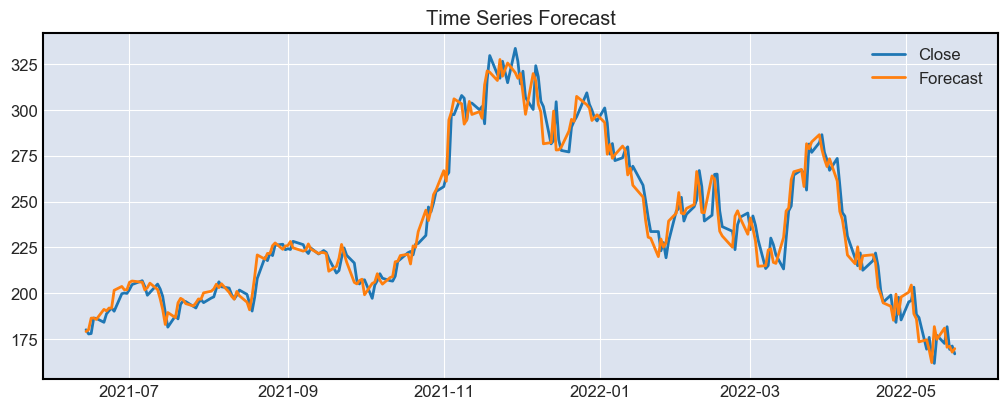

In [36]:
plt.figure(figsize = (12.33, 4.5))
plt.title('Time Series Forecast')
plt.plot(df9[['Close','Forecast']])
plt.legend(['Close', 'Forecast'])
plt.show()

# Conclusion

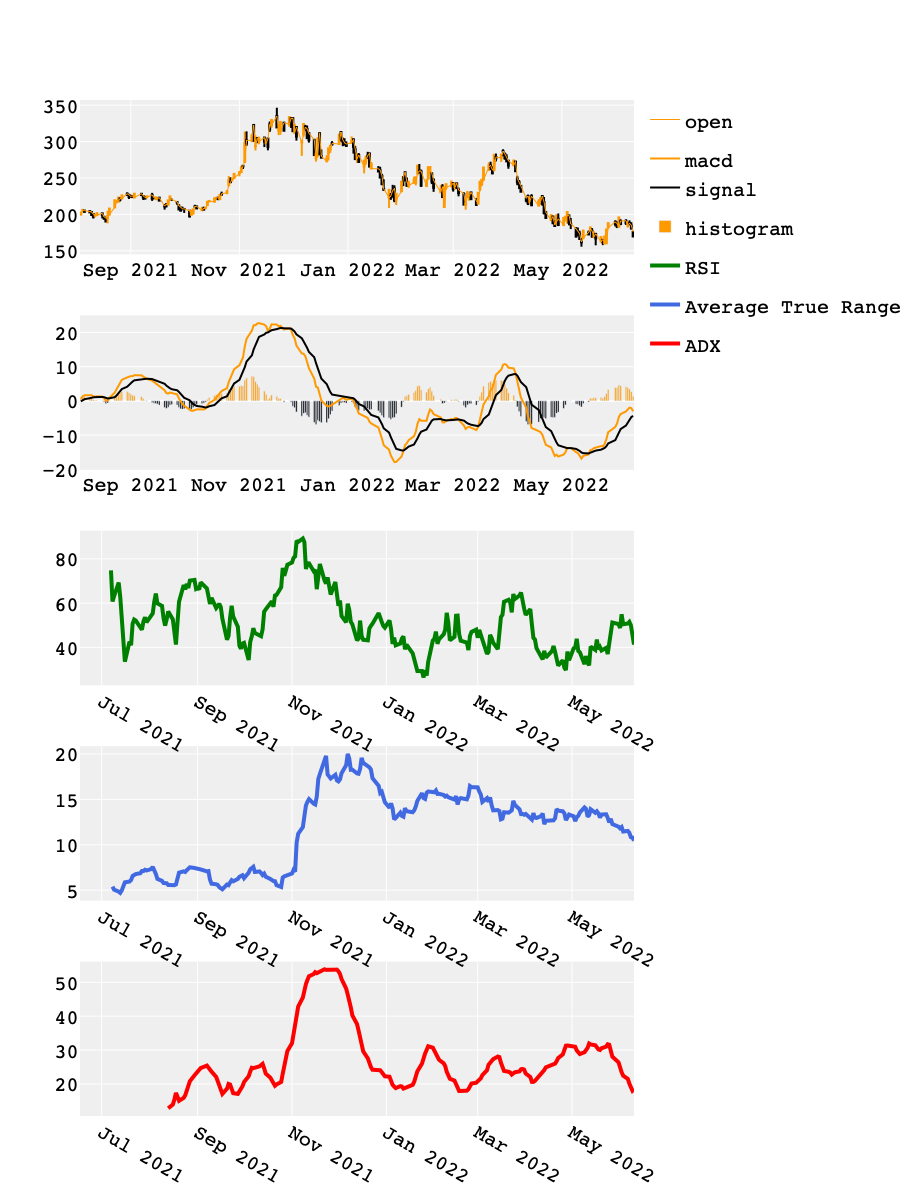

In [37]:
# Construct a 2 x 1 Plotly figure
fig = make_subplots(rows=5, cols=1)
# price Line
fig.append_trace(
    go.Scatter(
        x=df1.index,
        y=df1['Open'],
        line=dict(color='#ff9900', width=1),
        name='open',
        # showlegend=False,
        legendgroup='1',
    ), row=1, col=1
)
# Candlestick chart for pricing
fig.append_trace(
    go.Candlestick(
        x=df1.index,
        open=df1['Open'],
        high=df1['High'],
        low=df1['Low'],
        close=df1['Adj Close'],
        increasing_line_color='#ff9900',
        decreasing_line_color='black',
        showlegend=False
    ), row=1, col=1
)
# Fast Signal (%k)
fig.append_trace(
    go.Scatter(
        x=df1.index,
        y=df1['MACD'],
        line=dict(color='#ff9900', width=2),
        name='macd',
        # showlegend=False,
        legendgroup='2',
    ), row=2, col=1
)
# Slow signal (%d)
fig.append_trace(
    go.Scatter(
        x=df1.index,
        y=df1['Signal'],
        line=dict(color='#000000', width=2),
        # showlegend=False,
        legendgroup='2',
        name='signal'
    ), row=2, col=1
)
# Colorize the histogram values
colors = np.where(df1['Histogram'] < 0, '#000', '#ff9900')
# Plot the histogram
fig.append_trace(
    go.Bar(
        x=df1.index,
        y=df1['Histogram'],
        name='histogram',
        marker_color=colors,
    ), row=2, col=1
)
fig.append_trace(go.Scatter(x=df7.index, y=df7['rsi'], name='RSI',
                         line = dict(color='green', width=4)), row = 3, col = 1)

fig.append_trace(go.Scatter(x=df3.index, y=df3['ATR'], name='Average True Range',
                         line = dict(color='royalblue', width=4)), row = 4, col = 1 )

fig.append_trace(go.Scatter(x=df6.index, y=df6['ADX'], name='ADX',
                         line = dict(color='red', width=4)), row = 5, col = 1)


# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    height=1200, width=1200,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)

# Update options and show plot
fig.update_layout(layout)
fig.show()